In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

## Logistic Regression

In [2]:
import requests
import os

def fetch():
    path = 'nba.csv'
    if not os.path.exists(path):
        url = 'https://stats.nba.com/stats/leaguegamelog/'
        params = (
            ('Counter', '0'),
            ('DateFrom', ''),
            ('DateTo', ''),
            ('Direction', 'ASC'),
            ('LeagueID', '00'),
            ('PlayerOrTeam', 'T'),
            ('Season', '2017-18'),
            ('SeasonType', 'Regular Season'),
            ('Sorter', 'DATE'),
        )
        headers = {
            'User-Agent': 'PostmanRuntime/7.4.0'
        }
        response = requests.get(url, params=params, headers=headers)
        data = response.json()['resultSets'][0]
        df = pd.DataFrame(data=data['rowSet'], columns=data['headers'])
        df.to_csv(path, index=False)
        return df
    else:
        return pd.read_csv(path)
    
df = fetch()

In [3]:
df.iloc[0]

SEASON_ID                            22017
TEAM_ID                         1610612744
TEAM_ABBREVIATION                      GSW
TEAM_NAME            Golden State Warriors
GAME_ID                           21700002
GAME_DATE                       2017-10-17
MATCHUP                        GSW vs. HOU
WL                                       L
MIN                                    240
FGM                                     43
FGA                                     80
FG_PCT                               0.538
FG3M                                    16
FG3A                                    30
FG3_PCT                              0.533
FTM                                     19
FTA                                     21
FT_PCT                               0.905
OREB                                     6
DREB                                    35
REB                                     41
AST                                     34
STL                                      5
BLK        

In [4]:
df['WON'] = df['WL'].astype('category').cat.codes
half = df[['TEAM_NAME', 'GAME_ID', 'FG_PCT', 'WON']]
pairs = half.groupby('GAME_ID')
games = pairs.first().join(pairs.last(), rsuffix='_OPP')
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                         0.409
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                     0.458
WON_OPP                            1
Name: 21700001, dtype: object

In [5]:
games = games.drop('WON_OPP', axis=1)
games['FG_PCT_DIFF'] = games['FG_PCT'] - games['FG_PCT_OPP']
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                         0.409
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                     0.458
FG_PCT_DIFF                   -0.049
Name: 21700001, dtype: object

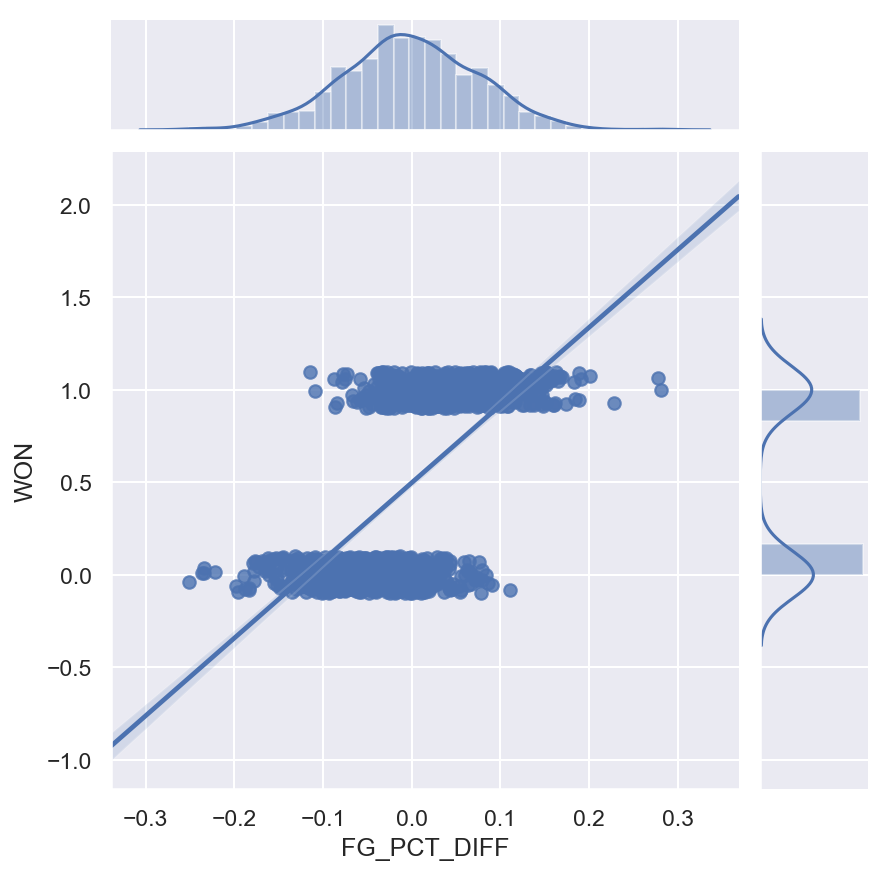

In [15]:
sns.jointplot('FG_PCT_DIFF', 'WON', 
              kind='reg', y_jitter=0.1,
              data=games);

In [16]:
bins = pd.cut(games['FG_PCT_DIFF'], 20)
mids = [(b.left + b.right)/2 for b in bins]
games['WON'].groupby(mids).size()

-0.2380      4
-0.2110      2
-0.1845     11
-0.1580     25
-0.1315     33
-0.1047     59
-0.0781    108
-0.0515    128
-0.0249    187
 0.0017    174
 0.0283    156
 0.0549    111
 0.0815    108
 0.1079     65
 0.1345     31
 0.1615     19
 0.1880      6
 0.2410      1
 0.2675      2
Name: WON, dtype: int64

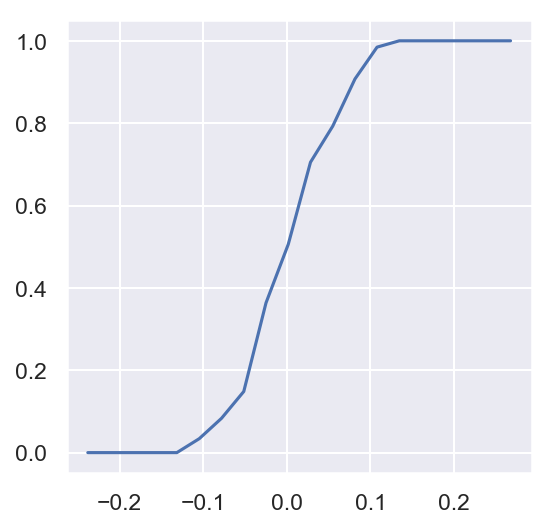

In [17]:
win_rates = games['WON'].groupby(mids).agg(lambda s: sum(s)/len(s))
win_rates.plot();

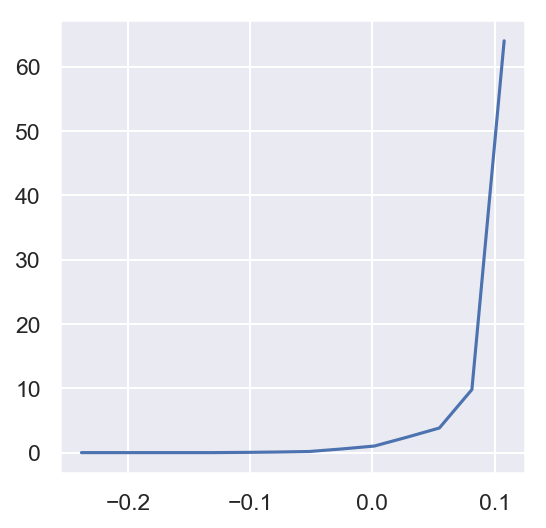

In [18]:
(win_rates / (1 - win_rates)).plot();

/Users/denero/anaconda3/envs/100/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


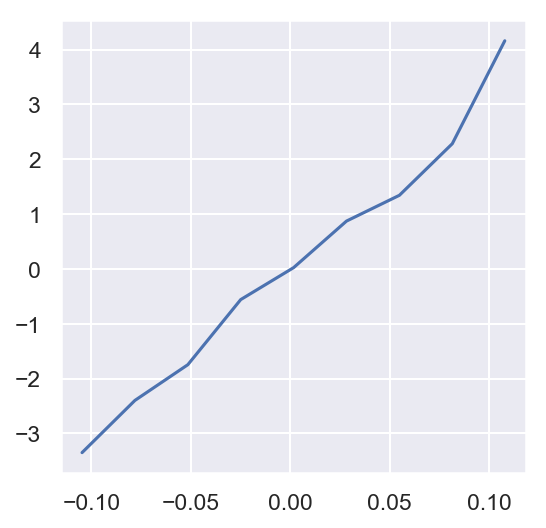

In [19]:
np.log(win_rates / (1 - win_rates)).plot();

One way to model the relationship between vector-valued $X$ and the conditional distribution of a binary categorical $Y \in {0, 1}$ is to assume that the log odds ratio is linear in $X$:

$$\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) = X^T \beta$$

Abbreviate $P(Y=1|X)$ as $p$ and $X^T \beta$ as $t$, then:

\begin{align*}
\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) &= X^T \beta && \text{} \\[10pt]
\log \left( \frac{p}{1-p} \right) &= t && \text{; Abbreviate and complement rule} \\[10pt]
\frac{p}{1-p} &= \exp(t) && \text{; exponentiate both sides} \\[10pt]
p &= \exp(t) - p \exp(t) && \text{; multiply by $1-p$} \\[10pt]
p (1 + \exp(t)) &= \exp(t) && \text{; add $p \exp(t)$ and factor out $p$} \\[10pt]
p &= \frac{\exp(t)}{1 + \exp(t)} && \text{; divide by $1 + \exp(t)$} \\[10pt]
p &= \frac{1}{1 + \exp(-t)} && \text{; multiply by $\frac{\exp(-t)}{\exp(-t)}$} \\[10pt]
P(Y=1|X) &= \frac{1}{1 + \exp(-X^T \beta)} && \text{; Unabbreviate}
\end{align*}

This transformation is called the logistic function, traditionally denoted $\sigma$ (sigma).

$$\sigma(t) = \frac{1}{1 + \exp(-t)}$$

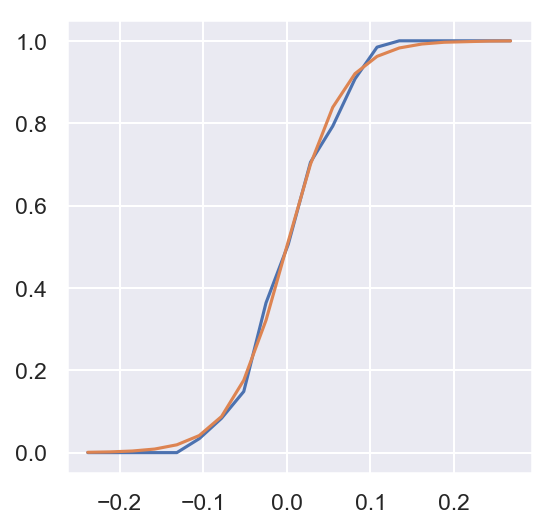

In [20]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

fg_pct_diffs = np.array(win_rates.index)
win_rates.plot();
plt.plot(fg_pct_diffs, sigma(fg_pct_diffs * 30));

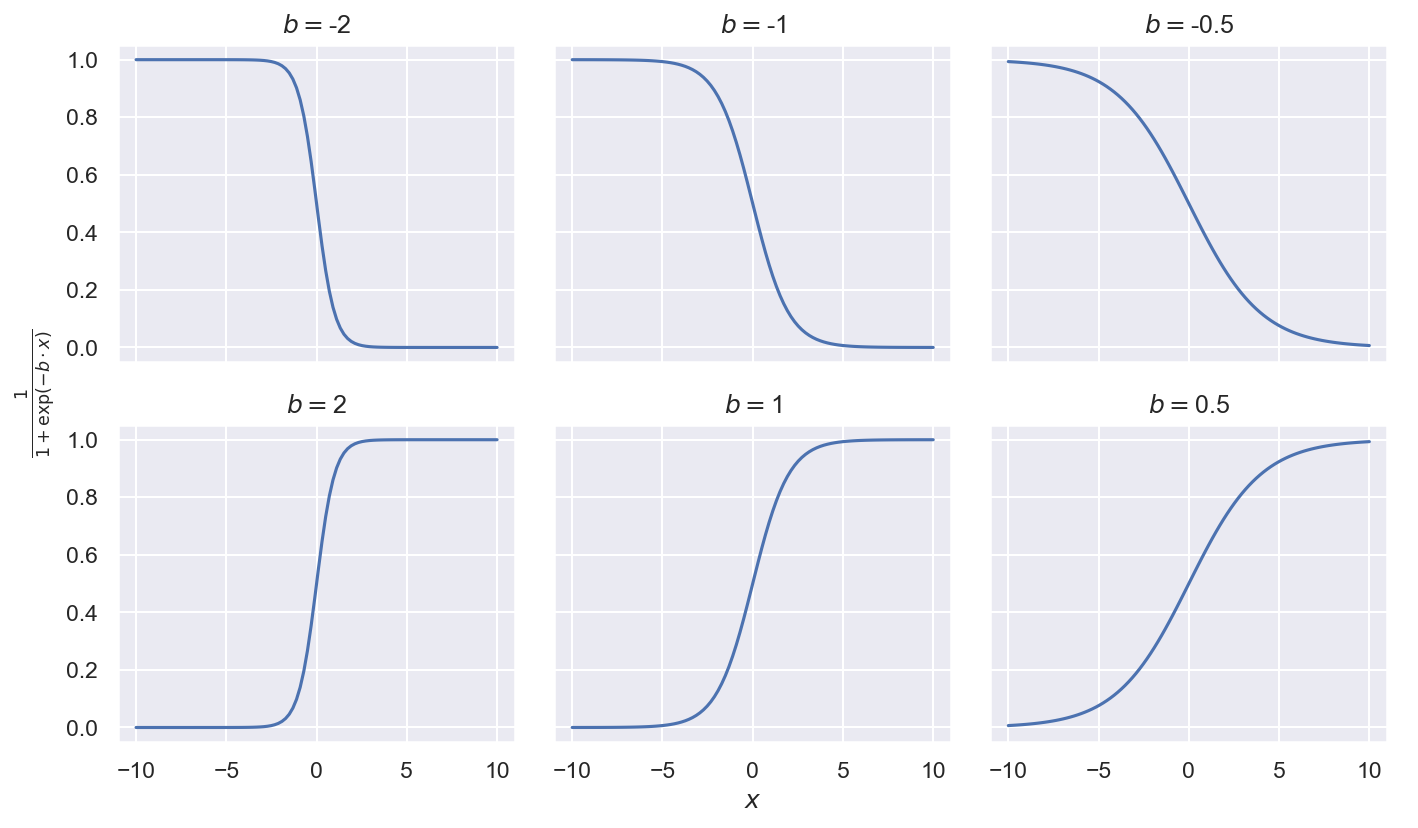

In [21]:
def flatten(li): 
    return [item for sub in li for item in sub]

bs = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, b in zip(flatten(axes), bs):
    ys = sigma(xs * b)
    ax.plot(xs, ys)
    ax.set_title(r'$ b = $' + str(b))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False,
                left=False, right=False)
plt.grid(False)
plt.xlabel('$x$')
plt.ylabel(r'$ \frac{1}{1+\exp(-b \cdot x)} $')
plt.tight_layout()

## Log Loss (a.k.a., Cross-Entropy Loss)

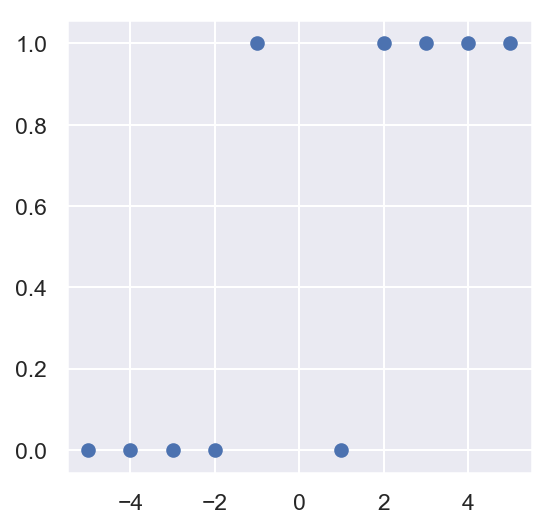

In [22]:
toy = pd.DataFrame({
    'X': [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
    'Y': [ 0,  0,  0,  0,  1, 0, 1, 1, 1, 1]
})
plt.scatter(toy['X'], toy['Y']);

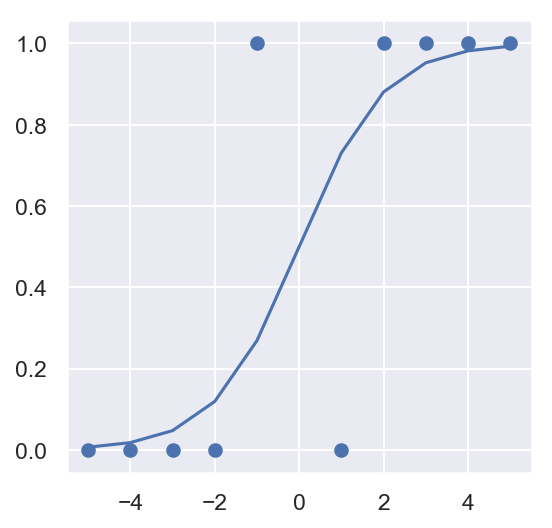

In [23]:
plt.scatter(toy['X'], toy['Y']);
plt.plot(toy['X'], sigma(toy['X']));

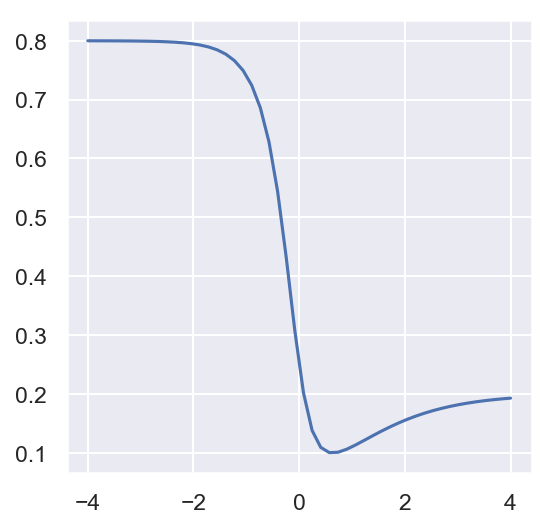

In [24]:
def empirical_risk(b, loss):
    y_hats = sigma(toy['X'] * b)
    losses = [loss(y, y_hat) for y, y_hat in zip(toy['Y'], y_hats)]
    return np.average(losses)

def squared_loss(y, y_hat):
    return (y - y_hat) ** 2

bs = np.linspace(-4, 4, 50)

plt.plot(bs, [empirical_risk(b, squared_loss) for b in bs]);

Fix an individual and let $\hat{p}$ be our predicted probability of the correct class for that individual. If the individual's class is 1, then $\hat{p}$ is our predicted chance that their class is 1, and if the individual's class is 0, then $\hat{p}$ is our predicted chance that their class is 0.

Regardless of whether the individual's class is 1 or 0, $\hat{p}$ is the predicted chance of the *correct* class. So here are some reasonable stipulations for a loss function.

- If $\hat{p} = 1$ then there should be no loss.
- If $\hat{p}$ is high, the loss should be small.
- If $\hat{p}$ is low, the loss should be large.
- Whatever $\hat{p}$ is, the loss should be non-negative.

Because $\hat{p}$ is between 0 and 1, the function $\hat{p} \rightarrow -\log(\hat{p})$ has all of these properties.

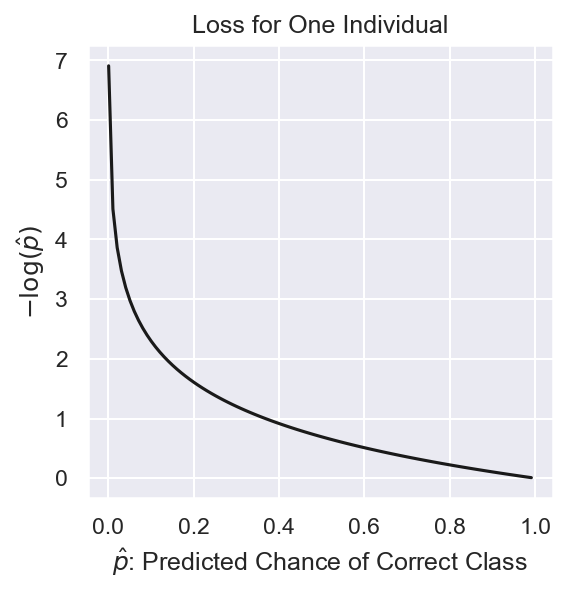

In [25]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$\hat{p}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(\hat{p})$')
plt.title('Loss for One Individual');

There are many other functions that have these properties. But this one has other nice properties and interpretations in the context of predictions. You might see some of them in more advanced classes, and you will see one in this class as soon as we start calculating gradients.

### Predicted Probability of the Correct Class

For individual $i$, let $p(x_i)$ be the predicted chance that individual $i$ belongs to class 1.

For individual $i$, let $\hat p_i$ be the predicted chance of the correct class. Then,

- $\hat p_i = p(x_i)$ if the class for individual $i$ is 1.
- $\hat p_i = 1 - p(x_i)$ if the class for individual $i$ is 0.

The figure below assumes that we just have one scalar feature $x$. The blue graph shows the function $p(x_i)$ that is our prediction for the chance of blue. The dots represent six individuals shown in their true colors. For each individual $i$, the length of the vertical line segment is $\hat{p_i}$, our predicted chance of the individual's correct class.

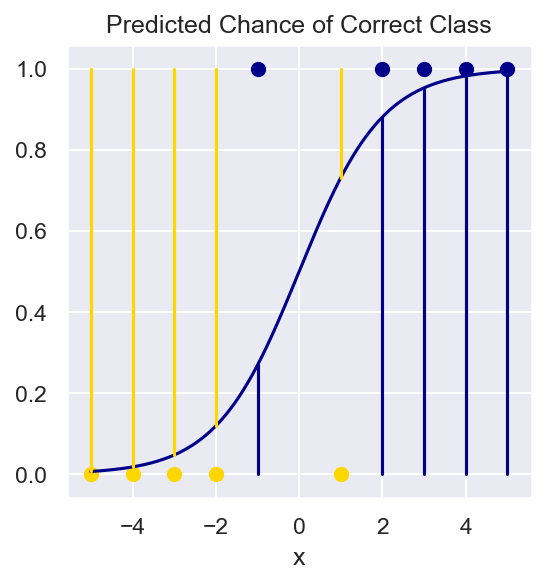

In [28]:
# Predicted chance of class 1.
x = np.arange(-5, 5, 0.01)
px = sigma(x)
plt.plot(x, px, color = 'darkblue')

def add_points(xs, y, color):
    plt.scatter(xs, [y] * len(xs), color=color, s=40)
    for x in xs:
        plt.plot([x, x], [1-y, sigma(x)], color=color)

add_points(np.array([-5, -4, -3, -2, 1]), 0, 'gold')
add_points(np.array([-1, 2, 3, 4, 5]), 1, 'darkblue')
        
plt.xlabel('x')
plt.title('Predicted Chance of Correct Class');

A compact way to write this loss in a single expression, where $y_i$ is the class for individual $i$, is:

$$
-y_i\log(p(x_i)) - (1-y_i)\log(1-p(x_i))
$$

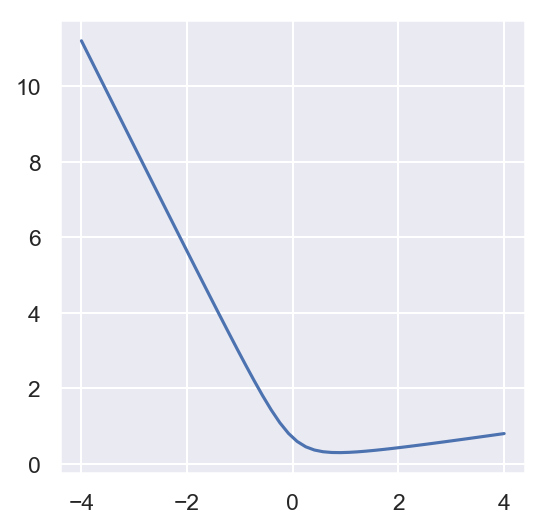

In [29]:
def log_loss(y, y_hat):
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

plt.plot(bs, [empirical_risk(b, log_loss) for b in bs]);

## Applying Logistic Regression

In [30]:
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                         0.409
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                     0.458
FG_PCT_DIFF                   -0.049
Name: 21700001, dtype: object

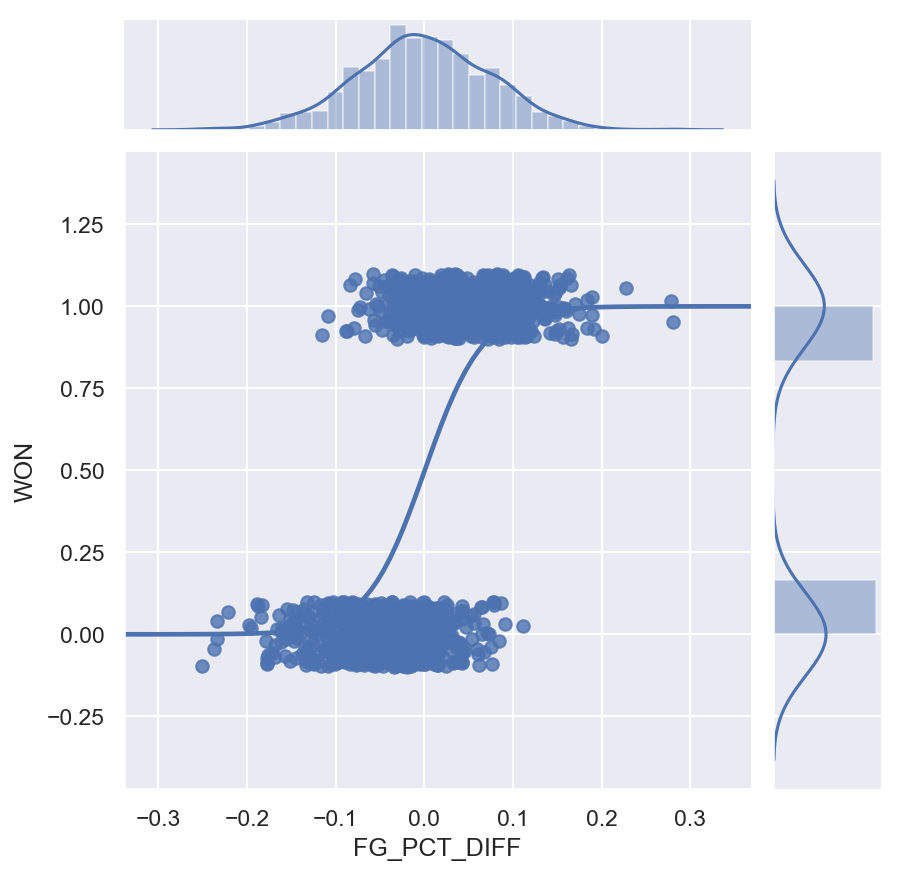

In [31]:
sns.jointplot('FG_PCT_DIFF', 'WON', 
              kind='reg', y_jitter=0.1, 
              logistic=True, ci=None,
              data=games);

In [32]:
def predict(beta):
    return sigma(games['FG_PCT_DIFF'] * beta)

def risk(beta):
    y_hat = predict(beta)
    y = games['WON']
    losses = -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)
    return np.average(losses)

In [33]:
from scipy.optimize import minimize

minimize(risk, 1)

      fun: 0.42957549456281086
 hess_inv: array([[3723.16404667]])
      jac: array([-1.82539225e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([30.57883679])

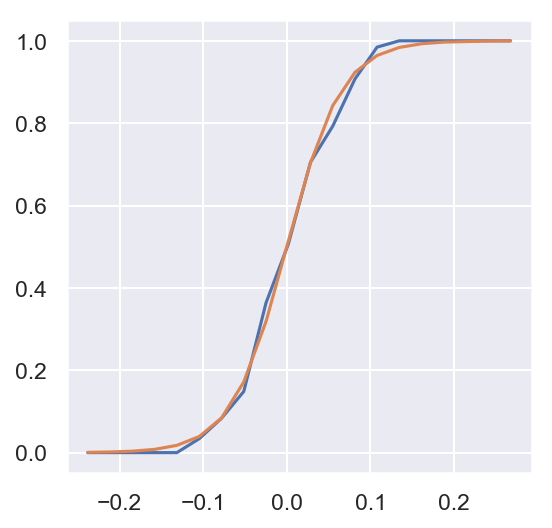

In [34]:
b = minimize(risk, 1)['x'][0]
win_rates.plot();
plt.plot(fg_pct_diffs, sigma(fg_pct_diffs * b));